In [280]:
import altair as alt
alt.data_transformers.enable('csv')
alt.renderers.enable('notebook')
alt.themes.enable('vox')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [208]:
df = pd.read_csv('2019_custom_contracts_2019-10-11.csv')
cost_cols = ['CT Bus','CT Vanpool','ET Bus','KCM Bus','KCM Vanpool','KCM HFG','KCM Admin Fee',
             'KCM Card Fees','KT Bus','KT Vanpool','PT Bus','PT Vanpool','ST']
# Convert columns to numeric
df[cost_cols] = df[cost_cols].apply(pd.to_numeric, errors='coerce')
df['total_contract'] = df[cost_cols].sum(axis=1)
transit_cost_cols = ['CT Bus','ET Bus','KCM Bus','KT Bus','PT Bus','ST']
df['transit_cost'] = df[transit_cost_cols].sum(axis=1)
# Note: new accounts have no pricing period
df['pricing_period_start'] = pd.to_datetime(df['Reporting Period Start Date'], format='%d-%b-%y')
df['pricing_period_end'] = pd.to_datetime(df['Reporting Period End Date'], format='%d-%b-%y')
df['pricing_period_end'] = df['pricing_period_end'].values.astype('datetime64[M]')
# Filtering out accounts with pricing period start date before Nov. 2017 
# Can't get ORCA data from before this time
# Also excludes new contracts with no ORCA history(44 out of 78 remain)
# In January: update '2019_custom_contracts_2019-10-11.csv' with 2020 contract data
df = df[df['pricing_period_start']>='2017-11-01']
# Create mon-year column using first day of month to match
df['start_year'] = df['pricing_period_start'].dt.year.astype(str)
df['start_month'] = df['pricing_period_start'].dt.month.astype(str)
df['start_mon-year'] = pd.to_datetime(df['start_year'] + df['start_month'],format='%Y%m')
df['end_year'] = df['pricing_period_end'].dt.year.astype(str)
df['end_month'] = df['pricing_period_end'].dt.month.astype(str)
df['end_mon-year'] = pd.to_datetime(df['end_year'] + df['end_month'],format='%Y%m')

# ORCA Pricing Summary data
ps = pd.read_csv('Pricing Summary_2017-11_to_2019-10.csv')
ps['mon-year'] = pd.to_datetime(ps['Year'].astype(str) + ps['Month'],format='%Y%B')

# Join contract and pricing summary data
df = pd.merge(df, ps, left_on='BA ID', right_on='Institution Id')
# Filter out months outside of pricing period
df = df[(df['mon-year']>=df['start_mon-year']) & (df['mon-year']<=df['end_mon-year'])]
# Groupby account and agency and summarize
df = df.groupby(['Business Account','BA ID','Service Participant Name']).agg({
    'Boardings':'sum',
    'EPurse Equivalent':'sum',
    'CT Bus':'first',
    'CT Trip Rate':'first',
    'CT Bus':'first',
    'ET Bus':'first',
    'ET Trip Rate':'first',
    'KCM Bus':'first',
    'KCM Trip Rate':'first',
    'KT Bus':'first',
    'KT Trip Rate':'first',
    'KT Growth Factor':'first',
    'PT Bus':'first',
    'PT Trip Rate':'first',
    'ST':'first',
    'ST Trip Rate':'first',
}).reset_index()

# Create columns for contracted transit totals and trip rates for respective agencies and accounts
def transit_cost(row):
    if row['Service Participant Name'] == 'Community Transit':
        return row['CT Bus']
    if row['Service Participant Name'] == 'Everett Transit':
        return row['ET Bus']
    if row['Service Participant Name'] == 'King County Metro':
        return row['KCM Bus']
    if row['Service Participant Name'] == 'Kitsap Transit':
        return row['KT Bus']
    if row['Service Participant Name'] == 'Pierce Transit':
        return row['PT Bus']
    if row['Service Participant Name'] == 'Sound Transit':
        return row['ST']
def trip_rate(row):
    if row['Service Participant Name'] == 'Community Transit':
        return row['CT Trip Rate']
    if row['Service Participant Name'] == 'Everett Transit':
        return row['ET Trip Rate']
    if row['Service Participant Name'] == 'King County Metro':
        return row['KCM Trip Rate']
    if row['Service Participant Name'] == 'Kitsap Transit':
        return row['KT Trip Rate']
    if row['Service Participant Name'] == 'Pierce Transit':
        return row['PT Trip Rate']
    if row['Service Participant Name'] == 'Sound Transit':
        return row['ST Trip Rate']
df['contract_amt'] = df.apply(lambda row: transit_cost(row), axis=1)
df['contract_trip_rate'] = df.apply(lambda row: trip_rate(row), axis=1)
df = df[['Business Account','BA ID','Service Participant Name','Boardings',
    'EPurse Equivalent','contract_amt','contract_trip_rate']]
# Exclude partial years (i.e. new contracts, terminated contracts), 
# weird growth factors (e.g. WA State), other outliers
df = df[~df['BA ID'].isin([5699,4989,3420,2693,5235])]

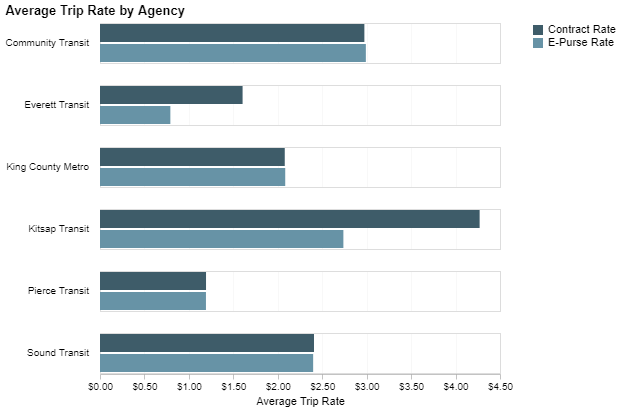

In [295]:
# By Agency
agency = df.groupby('Service Participant Name').agg({
    'Boardings':'sum',
    'EPurse Equivalent':'sum',
    'contract_amt':'sum',
})
agency['epurse_trip_rate'] = agency['EPurse Equivalent'] / agency['Boardings']
agency['contract_trip_rate'] = agency['contract_amt'] / agency['Boardings']
agency_etr = agency[['epurse_trip_rate']].copy().reset_index()\
    .rename(columns={'epurse_trip_rate':'rate'})
agency_etr['rate_type'] = 'E-Purse Rate'
agency_ctr = agency[['contract_trip_rate']].copy().reset_index()\
    .rename(columns={'contract_trip_rate':'rate'})
agency_ctr['rate_type'] = 'Contract Rate'
agency = pd.concat([agency_etr,agency_ctr])

alt.Chart(agency).mark_bar().encode(
    x=alt.X('rate:Q', title='Average Trip Rate', axis=alt.Axis(format='$.2f')),
    y=alt.Y('rate_type:O', axis=None),
    color=alt.Color('rate_type:N', legend=alt.Legend(title=None)),
    row=alt.Row('Service Participant Name:N',
        title=None,
        header=alt.Header(labelAngle=0)),
    tooltip=['rate_type', alt.Tooltip('rate:Q', format='$.2f')]
).properties(
    title='Average Trip Rate by Agency'
).configure_axisX(
    labelFlush=False
)

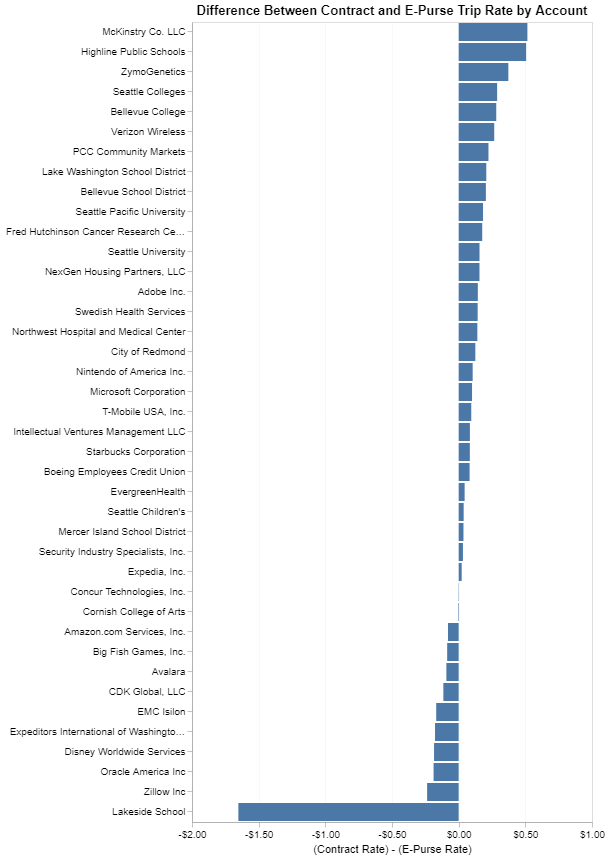

In [297]:
# By account
account = df.groupby('Business Account').agg({
    'Boardings':'sum',
    'EPurse Equivalent':'sum',
    'contract_amt':'sum'
})
account['epurse_trip_rate'] = account['EPurse Equivalent'] / account['Boardings']
account['contract_trip_rate'] = account['contract_amt'] / account['Boardings']
account['difference'] = account['contract_trip_rate'] - account['epurse_trip_rate']
account = account[['difference']].sort_values(by='difference', ascending=False).reset_index()

alt.Chart(account).mark_bar().encode(
    x=alt.X('difference:Q', scale=alt.Scale(domain=(-2, 1)), title='(Contract Rate) - (E-Purse Rate)', 
            axis=alt.Axis(format='$.2f', values=[-2,-1.5,-1,-.5,0,.5,1])),
    y=alt.Y('Business Account:O', sort=alt.EncodingSortField(field='difference', order='descending'),
           title=None),
    tooltip=['Business Account', alt.Tooltip('difference:Q', format='$.2f')]
).properties(
    title='Difference Between Contract and E-Purse Trip Rate by Account'
).configure_axisX(
    labelFlush=False
)

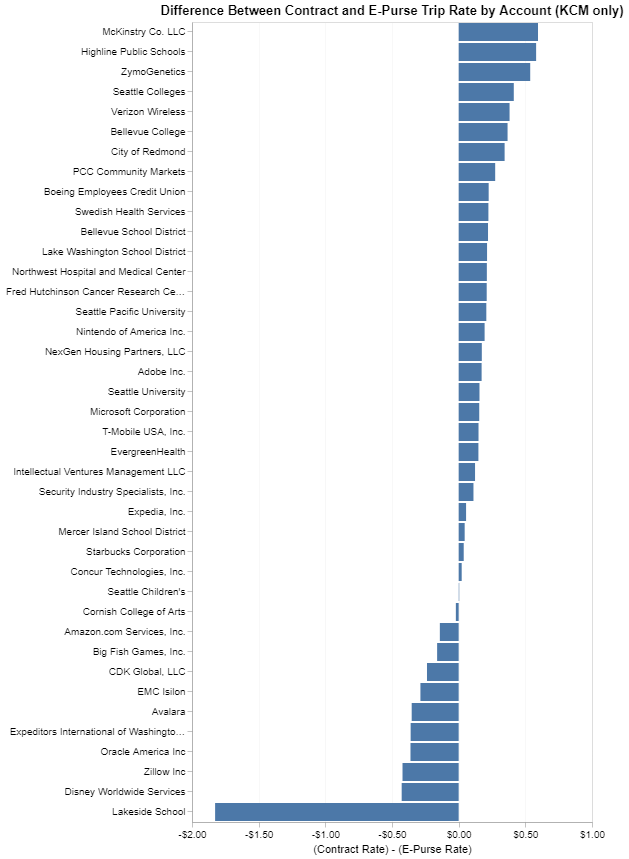

In [298]:
# By account (KCM only)
account = df[df['Service Participant Name']=='King County Metro'].groupby('Business Account').agg({
    'Boardings':'sum',
    'EPurse Equivalent':'sum',
    'contract_amt':'sum'
})
account['epurse_trip_rate'] = account['EPurse Equivalent'] / account['Boardings']
account['contract_trip_rate'] = account['contract_amt'] / account['Boardings']
account['difference'] = account['contract_trip_rate'] - account['epurse_trip_rate']
account = account[['difference']].sort_values(by='difference', ascending=False).reset_index()

alt.Chart(account).mark_bar().encode(
    x=alt.X('difference:Q', scale=alt.Scale(domain=(-2, 1)), title='(Contract Rate) - (E-Purse Rate)', 
            axis=alt.Axis(format='$.2f', values=[-2,-1.5,-1,-.5,0,.5,1])),
    y=alt.Y('Business Account:O', sort=alt.EncodingSortField(field='difference', order='descending'),
           title=None),
    tooltip=['Business Account', alt.Tooltip('difference:Q', format='$.2f')]
).properties(
    title='Difference Between Contract and E-Purse Trip Rate by Account (KCM only)'
).configure_axisX(
    labelFlush=False
)